# ResNet

- **Training set**: LO_SARD102
- **Test/Validation set:** LO_SARD102
- **Features**: word2vec sequence (100)
- **Class imbalance processing**: weights

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report

X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_X_train.npy', mmap_mode='r')
Y_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_Y_train.npy', mmap_mode='r')

X_val = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_X_val.npy', mmap_mode='r')
Y_val = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_Y_val.npy', mmap_mode='r')

X_test =  numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_X_test.npy',  mmap_mode='r')
Y_test =  numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_Y_test.npy',  mmap_mode='r')

classWeights = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD_w2vseq_weights_train.npy')
classWeights = { 0: classWeights[0], 1: classWeights[1] }
print(f"class weights: {classWeights}\n")

print("Y_train:")
print(Counter(Y_train))
print(X_train.shape)
print(Y_train.shape)

print("\nY_val:")
print(Counter(Y_val))
print(X_val.shape)
print(Y_val.shape)

print("\nY_test:")
print(Counter(Y_test))
print(X_test.shape)
print(Y_test.shape)

train_gen = ResNetDataGenerator(_X=X_train, _y=Y_train, batch_size=512)
val_gen =   ResNetDataGenerator(_X=X_val,   _y=Y_val,   batch_size=512)
test_gen =  ResNetDataGenerator(_X=X_test,  _y=Y_test,  batch_size=512)

class weights: {0: 0.5203559417625802, 1: 12.781426372498716}

Y_train:
Counter({0.0: 95746, 1.0: 3898})
(99644, 100, 100)
(99644,)

Y_val:
Counter({0.0: 31975, 1.0: 1240})
(33215, 100, 100)
(33215,)

Y_test:
Counter({0.0: 31916, 1.0: 1299})
(33215, 100, 100)
(33215,)


## Build & train keras model

In [4]:
# https://keras.io/api/applications/resnet/#resnet50-function
model = applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(100, 100, 1),
    pooling=None,
    classes=2
)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(train_gen,
                    epochs=8,
                    verbose=True,
                    validation_data=val_gen,
                    class_weight=classWeights
                   )

Epoch 1/8
195/195 [==============================] - 105s 541ms/step - loss: 1.3184 - accuracy: 0.5364 - val_loss: 106211.7344 - val_accuracy: 0.9193
Epoch 2/8
195/195 [==============================] - 104s 535ms/step - loss: 0.4997 - accuracy: 0.7566 - val_loss: 0.8038 - val_accuracy: 0.6639
Epoch 3/8
195/195 [==============================] - 104s 536ms/step - loss: 0.1066 - accuracy: 0.9675 - val_loss: 0.0906 - val_accuracy: 0.9632
Epoch 4/8
195/195 [==============================] - 104s 535ms/step - loss: 0.0669 - accuracy: 0.9862 - val_loss: 0.0118 - val_accuracy: 0.9980
Epoch 5/8
195/195 [==============================] - 104s 535ms/step - loss: 0.0516 - accuracy: 0.9895 - val_loss: 0.0773 - val_accuracy: 0.9716
Epoch 6/8
195/195 [==============================] - 104s 535ms/step - loss: 0.0357 - accuracy: 0.9929 - val_loss: 0.0097 - val_accuracy: 0.9967
Epoch 7/8
195/195 [==============================] - 104s 535ms/step - loss: 0.0311 - accuracy: 0.9933 - val_loss: 0.0091 - v

## Evaluation

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     31916
         1.0       0.74      1.00      0.85      1299

    accuracy                           0.99     33215
   macro avg       0.87      0.99      0.92     33215
weighted avg       0.99      0.99      0.99     33215

Confusion matrix:
[[31468   448]
 [    6  1293]]

Confusion matrix (Percentages):
[[9.474e+01 1.349e+00]
 [1.800e-02 3.893e+00]]

Metrics:
Sensitivity (TPR): 0.995381
Specifity (TNR):   0.985963

FPR: 0.014037
FNR: 0.004619

Balanced accuracy: 0.990672

Test loss:	0.057563
Test accuracy:	0.986331


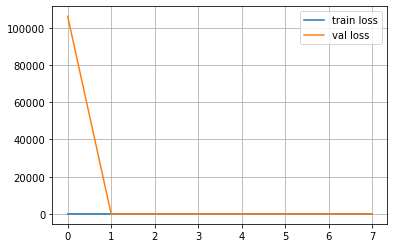

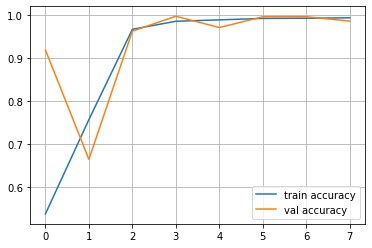

In [5]:
Y_pred = numpy.argmax( model.predict(test_gen) , axis=1 )

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(test_gen, verbose=False)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

plot_loss(history)
plot_accuracy(history)

In [6]:
model.save('ResNet_word2vec_weighted.h5')